In [1]:
from utils import *

import cv2

%matplotlib inline

# Morphological operations

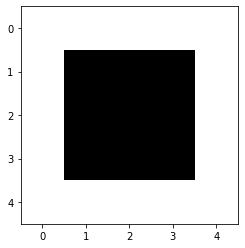

In [2]:
square = np.array([[0, 0, 0, 0, 0],
                   [0, 1, 1, 1, 0],
                   [0, 1, 1, 1, 0],
                   [0, 1, 1, 1, 0],
                   [0, 0, 0, 0, 0]], dtype=np.uint8)



plt.imshow(square, cmap="binary")

plt.show()

L'operazione di Erosion rimuove pixel dai bordi in un'immagine.

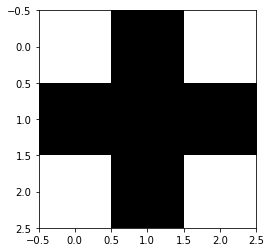

In [3]:
kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
#kernel = np.ones((3,3),np.uint8)

plt.imshow(kernel, cmap="binary")

plt.show()


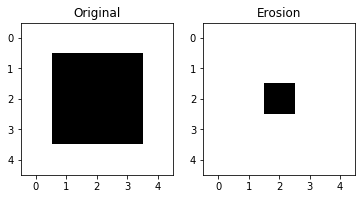

In [4]:

erosion = cv2.erode(square,kernel)
                    

fig = plt.figure(figsize=(6, 6))

a=fig.add_subplot(1, 2, 1)
plt.imshow(square, cmap="binary")
a.set_title("Original")

# Plot dilated image
a=fig.add_subplot(1, 2, 2)
plt.imshow(erosion, cmap="binary")
a.set_title("Erosion")

plt.show()

L'operazione di Dilation aggiunge pixel ai bordi in un'immagine.

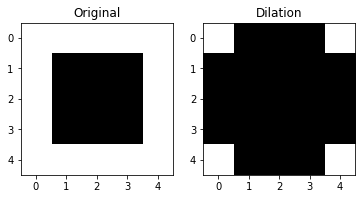

In [5]:

dilation = cv2.dilate(square,kernel)
                    

fig = plt.figure(figsize=(6, 6))

a=fig.add_subplot(1, 2, 1)
plt.imshow(square, cmap="binary")
a.set_title("Original")

# Plot dilated image
a=fig.add_subplot(1, 2, 2)
plt.imshow(dilation, cmap="binary")
a.set_title("Dilation")

plt.show()

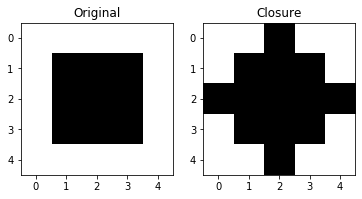

In [6]:

closure = cv2.erode(cv2.dilate(square,kernel),kernel)
                    

fig = plt.figure(figsize=(6, 6))

a=fig.add_subplot(1, 2, 1)
plt.imshow(square, cmap="binary")
a.set_title("Original")

# Plot dilated image
a=fig.add_subplot(1, 2, 2)
plt.imshow(closure, cmap="binary")
a.set_title("Closure")

plt.show()

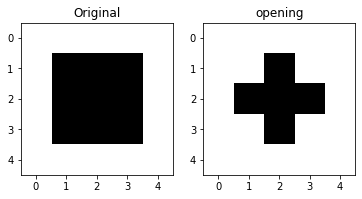

In [7]:
opening = cv2.dilate(cv2.erode(square,kernel),kernel)
                    

fig = plt.figure(figsize=(6, 6))

a=fig.add_subplot(1, 2, 1)
plt.imshow(square, cmap="binary")
a.set_title("Original")

# Plot dilated image
a=fig.add_subplot(1, 2, 2)
plt.imshow(opening, cmap="binary")
a.set_title("opening")

plt.show()

Vediamo gli effetti su un'immagine

In [8]:
# Load an color image in grayscale
image = cv2.imread(os.path.join(img_src,'airplanes.png'))

gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

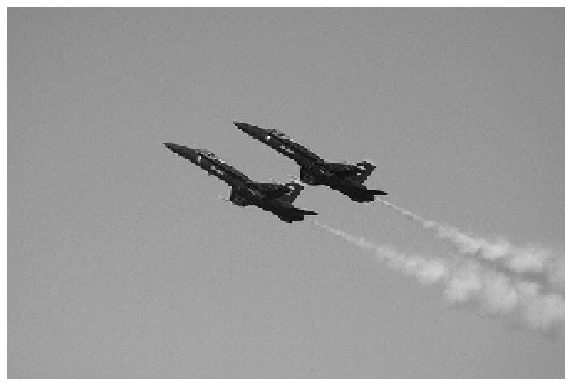

In [9]:
img_show(gray,cmap=cm.gray)

In [10]:
#image.mean()

#thresh = 255-(gray > 100).astype(np.uint8)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)



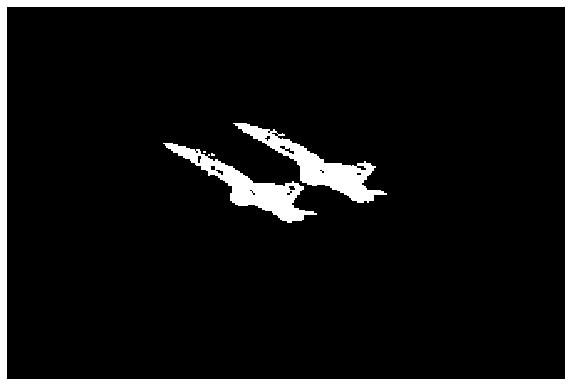

In [11]:

img_show(thresh,cmap='gray')

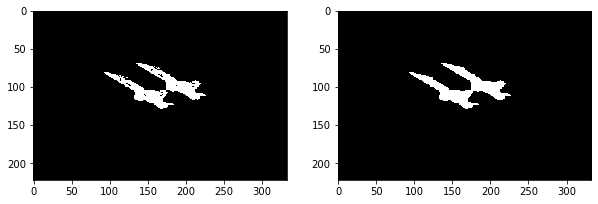

In [12]:
kernel = np.ones((3,3),np.uint8)

result = cv2.erode(cv2.dilate(thresh,kernel),kernel)

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(thresh,cmap=cm.gray)
plt.subplot(1,2,2)
plt.imshow(result,cmap=cm.gray)
plt.show()

# Multiple thresholds

In [13]:
def segment_by_quantile(image, q = 3):
    image_r = image.reshape(image.shape[0]*image.shape[1])
    ret = np.zeros(image_r.shape[0])
    quantiles_r = np.linspace(0,1,q)
    
    quantiles = np.quantile(image_r,quantiles_r)
        
    for i in range(image_r.shape[0]):
        for j,t in enumerate(quantiles):
            if image_r[i] >= t:
                ret[i] = j
    return ret.reshape(image.shape[0],image.shape[1])

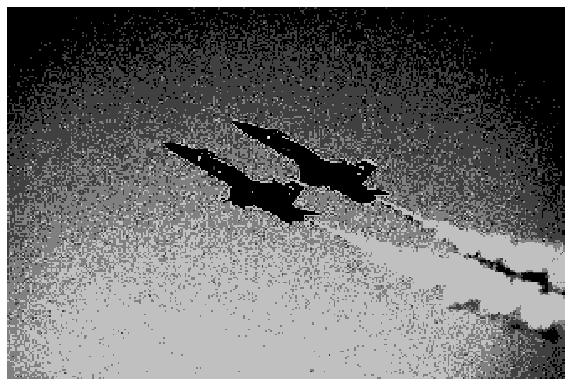

In [14]:
segmented = segment_by_quantile(gray,q=5)

img_show(segmented,cmap=cm.gray)

# Operazioni morfologiche

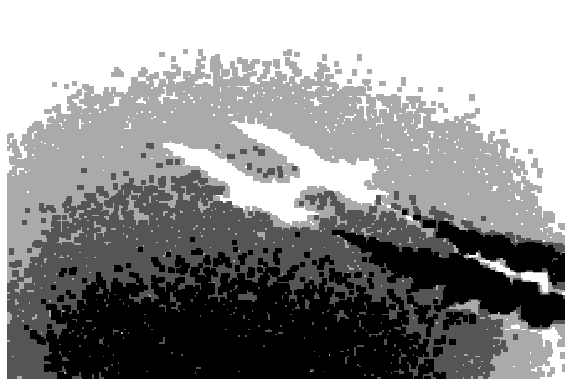

In [15]:
closing = cv2.dilate(cv2.erode(segmented,kernel),kernel)

img_show(closing,cmap='binary')

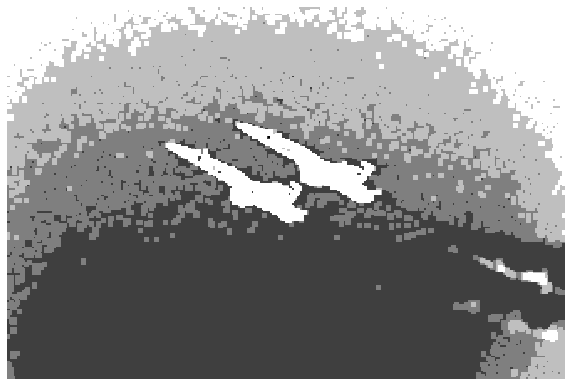

In [16]:
opening = cv2.erode(cv2.dilate(segmented,kernel),kernel)

img_show(opening,cmap='binary')

# Watershed segmentation

Per ottenere una segmentazione più accurata possiamo combinare operazioni morfologiche e watershed segmentation. 

L'operazione di apertura morfologica serve a rimuovere chiazze di bianco. Mentre per rimuovere piccoli buchi negli oggetti, possiamo utilizzare la chiusura morfologica. 

Queste operazioni garantiscono che la regione al centro degli oggetti sia individuabile come foreground e quella lontana dall'oggetto come background. Utilizzando l'operazione di erosione elimina i bordi dal foreground, mentre la dilatazione "ripulisce" il background. 

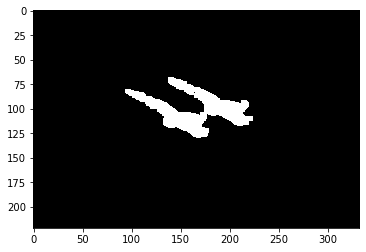

In [17]:
# noise removal
kernel = np.ones((3,3),np.uint8)


opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel)#, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel)#,iterations=3)

plt.imshow(sure_bg,cmap='gray')
plt.show()

Se il foreground contiene più oggetti, non è possibile separarli adeguatamente solo tramite erosione. 
Una tecnica comunemente usata è quella di marcare ogni punto con la distanza dal punto di background più vicino. I punti a distanza più grande rappresentano foreground sicuro. 


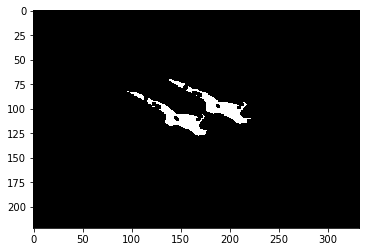

In [18]:

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)

#ret, sure_fg = cv2.threshold(dist_transform,0,255,cv2.THRESH_OTSU)
ret, sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0)


plt.imshow(sure_fg,cmap='gray')
plt.show()

In [19]:

# Finding unknown region
sure_fg = np.uint8(sure_fg)
#unknown = cv2.subtract(sure_bg,sure_fg)
unknown = sure_bg - sure_fg

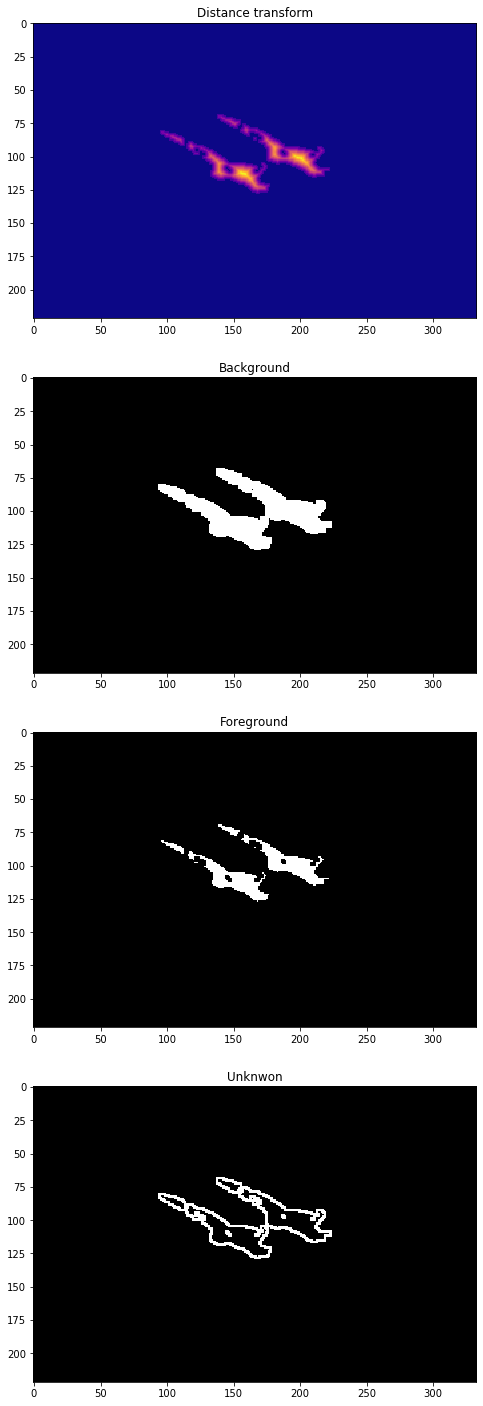

In [20]:
fig = plt.figure(figsize=(25, 25))


a=fig.add_subplot(4, 1, 1)
plt.imshow(dist_transform, cmap="plasma")
a.set_title("Distance transform")

a=fig.add_subplot(4, 1, 2)
plt.imshow(sure_bg, cmap="gray")
a.set_title("Background")


a=fig.add_subplot(4, 1, 3)
plt.imshow(sure_fg, cmap="gray")
a.set_title("Foreground")

a=fig.add_subplot(4, 1, 4)
plt.imshow(unknown, cmap="gray")
a.set_title("Unknwon")


plt.show()

A questo punto avremo delle zon che sono delle "vallate" di foreground e altre zone che sono background. 

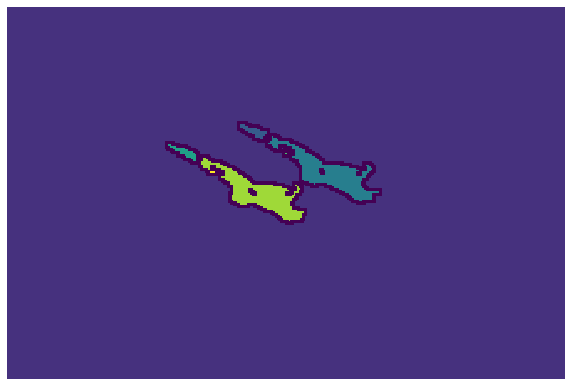

In [21]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

img_show(markers)

Applicando l'algoritmo di watershed segmentation sulle vallate trovate tramite la distance transform saremo infine in grado di identificare i bordi  degli oggetti in maniera accurata. 

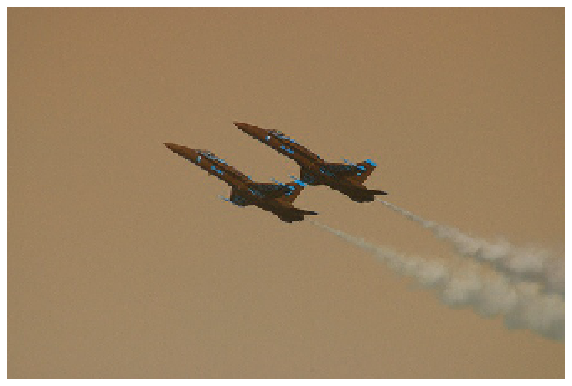

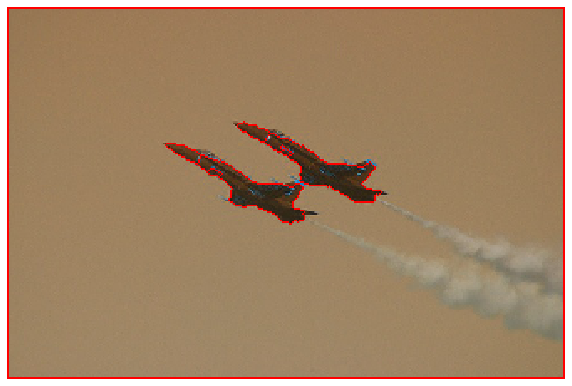

In [22]:
img_show(image,cmap='gray')

markers = cv2.watershed(image,markers)
image[markers == -1] = [255,0,0]


img_show(image)#cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Clustering

In [23]:
def featurize(im,use_coord = False):
    H, W = im.shape[:2]
    y, x = np.mgrid[:H, :W]
    if use_coord:
        feat = np.concatenate((y[..., np.newaxis], x[..., np.newaxis], im), 2).astype('float')
    else:
        feat = im
        
    return feat.reshape(feat.shape[0]*feat.shape[1], feat.shape[2]).astype('float')



def defeaturize(orig,im,use_coord = False):
    H, W, C = orig.shape
    if use_coord:
        return im.reshape(H, W, C+2).astype(np.uint8)[:,:,2:]
    else:
        return im.reshape(H, W, C).astype(np.uint8)

    

### Esercizio

Applicare una filter bank per estendere il numero di features alla funziona featurize

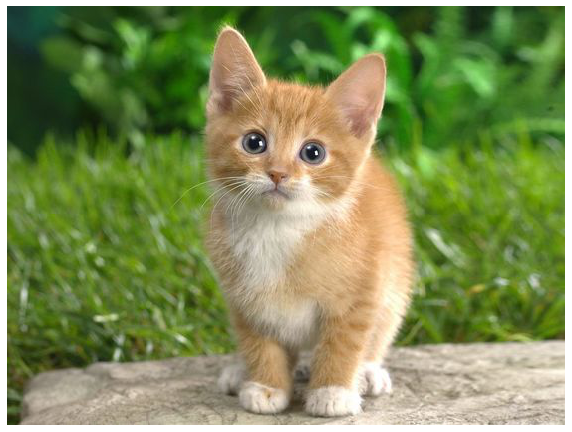

In [24]:
#image = cv2.imread(os.path.join(img_src,'airplanes.png'))
#image = cv2.imread(os.path.join(img_src,'cat.png'))
image = cv2.imread(os.path.join(img_src,'cat1.jpg'))
#image = cv2.imread(os.path.join(img_src,'mechanic.png'))


image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


img_show(image)

In [25]:
image.shape

(420, 560, 3)

In [26]:
image_n = featurize(image,True)
image_n.shape

(235200, 5)

In [27]:
image_n[:4]

array([[ 0.,  0., 25., 56., 51.],
       [ 0.,  1., 25., 56., 51.],
       [ 0.,  2., 25., 56., 51.],
       [ 0.,  3., 24., 55., 50.]])

In [28]:
x = image_n[0]

y = image_n[10]

print(x,y,np.sum((x-y)**2))

[ 0.  0. 25. 56. 51.] [ 0. 10. 27. 58. 53.] 112.0


In [29]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(image_n)


(235200, 5)


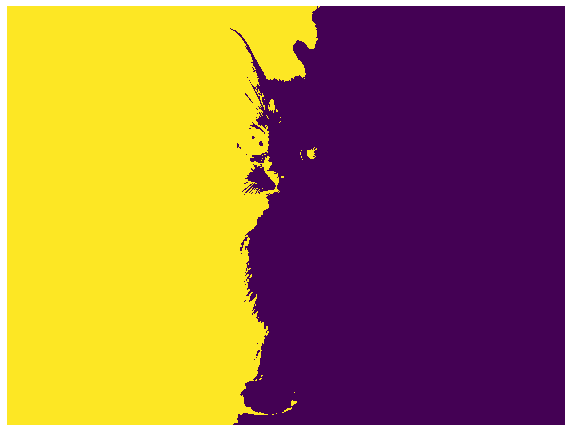

In [30]:
pic2show = kmeans.cluster_centers_[kmeans.labels_]

print(pic2show.shape)
#cluster_pic = defeaturize(image,pic2show,False)
cluster_pic = kmeans.labels_.reshape(image.shape[0],image.shape[1])

img_show(cluster_pic)

## MeanShift

In [31]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from skimage.color import rgb2lab


image_n = featurize(image,True)#image_lab[:,:,:2],False)
#image_lab = rgb2lab(image)
#image_n = featurize(image_lab[:,:,:2],False)



# Estimate bandwidth for meanshift algorithm    
bandwidth = estimate_bandwidth(image_n, quantile=0.1, n_samples=100)    
print("Estimated bandwidth : %d" % bandwidth)    


#ms = MeanShift(bandwidth = 40, bin_seeding=True)
ms = MeanShift(bandwidth = bandwidth, bin_seeding=True)

# Performing meanshift on flatImg    
ms.fit(image_n)




Estimated bandwidth : 122


MeanShift(bandwidth=122.08673237801415, bin_seeding=True, cluster_all=True,
          max_iter=300, min_bin_freq=1, n_jobs=None, seeds=None)

number of estimated clusters : 5


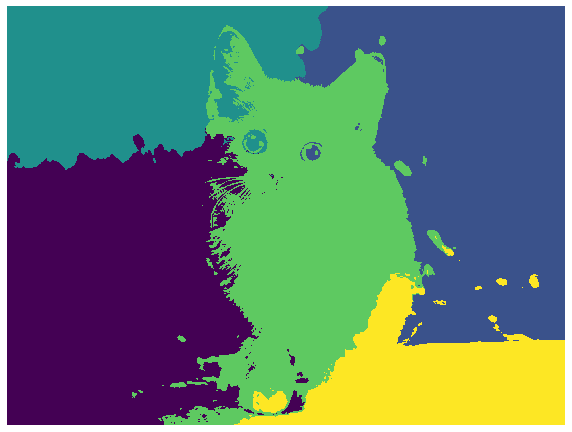

In [32]:

# (r,g,b) vectors corresponding to the different clusters after meanshift    
labels=ms.labels_

# Remaining colors after meanshift    
cluster_centers = ms.cluster_centers_    

# Finding and diplaying the number of clusters    
labels_unique = np.unique(labels)    
n_clusters_ = len(labels_unique)    
print("number of estimated clusters : %d" % n_clusters_)    

# Displaying segmented image    
segmentedImg = np.reshape(labels, image.shape[:2])  

img_show(segmentedImg)

# Conditional Random Fields

Esempio adattato da [Chris Choy](https://github.com/chrischoy/segmentation_lecture/blob/master/utils.py)

In [33]:
def whiten(im):
    H, W, C = im.shape
    # Flatten
    whitened_im = im.reshape(-1, C).astype('float')
    # Whiten the feature
    whitened_im -= np.mean(whitened_im, 0)
    whitened_im /= np.sqrt(np.mean(whitened_im ** 2, 0))
    return whitened_im.reshape(H, W, C)

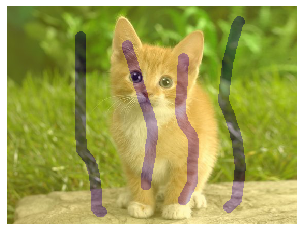

In [36]:

im = cv2.imread(os.path.join(img_src,'cat1.jpg'))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

outline = cv2.imread(os.path.join(img_src,'cat1_outline.png'))
outline = cv2.cvtColor(outline,cv2.COLOR_BGR2GRAY)


# l'outline ha tre possibili valori: 0,1 e 255. L'ultimo rappresenta valori non etichettati (e quindi da ignorare)
#plt.subplot(1, 2, 1)
#plt.imshow(im)
#plt.axis('off')
#plt.subplot(1, 2, 2)
#plt.imshow(cv2.cvtColor(outline[..., np.newaxis] * im, cv2.COLOR_BGR2RGB))
#plt.axis('off')
plt.imshow(im)
plt.imshow(outline,alpha=0.3)
plt.axis('off')
plt.show()

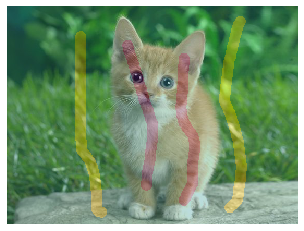

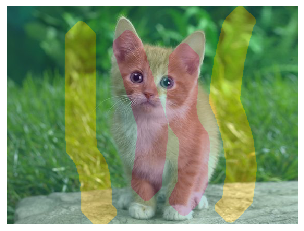

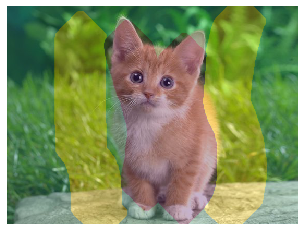

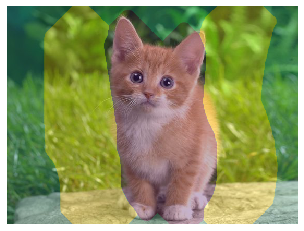

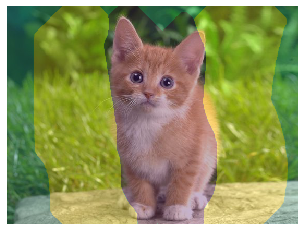

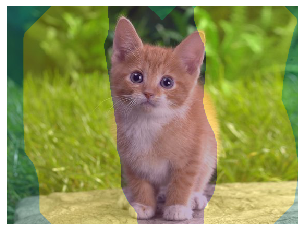

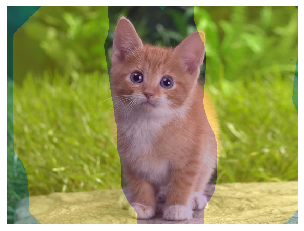

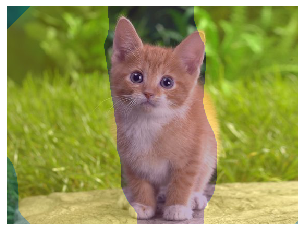

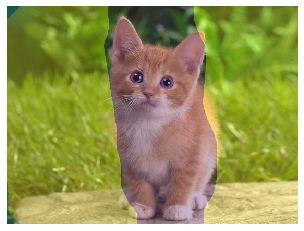

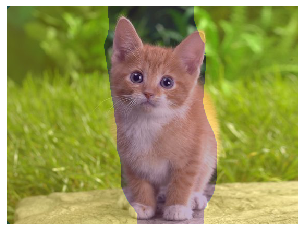

In [37]:

# Create a grid CRF
N_LABEL = 2
MAX_ITER = 200

# Normalizziamo l'immagine di input
feat = whiten(im)
H, W = outline.shape

# etichette
label = outline[1:H - 1, 1:W - 1]


def rbf_kernel(dist, sigma=3):
    return np.exp(- np.sum(dist ** 2, 2) / sigma)


# ogni cella è collegata alle celle adiacenti
curr_feat = feat[1:H - 1, 1:W - 1]
top, bottom, left, right = np.zeros((H, W)), np.zeros(
    (H, W)), np.zeros((H, W)), np.zeros((H, W))
top[1:H - 1,    1:W - 1] = rbf_kernel(curr_feat - feat[0:H - 2, 1:W - 1])
bottom[1:H - 1, 1:W - 1] = rbf_kernel(curr_feat - feat[2:H,     1:W - 1])
left[1:H - 1,   1:W - 1] = rbf_kernel(curr_feat - feat[1:H - 1, 0:W - 2])
right[1:H - 1,  1:W - 1] = rbf_kernel(curr_feat - feat[1:H - 1, 2:W])


# pairwise potential
compatibility = np.array([[-2, 0], [0, -2]])

# unary potential
unary = np.zeros((H, W, N_LABEL))

# Le probabilità di classe per ogni cella
logit = np.zeros((H, W, N_LABEL))
logit[:] = -1

# settiamo i valori di potenziale per le celle note
unary[outline == 255] = [0, 0]
unary[outline == 0] = [0, -3]
unary[outline == 1] = [-3, 0]

for curr_iter in range(MAX_ITER):

    score = np.exp(logit)
    prob = score / (np.sum(score, 2, keepdims=True) + 1e-6)

    # Message passing
    logit[1:H - 1, 1:W - 1] = (
        left[  1:H - 1, 1:W - 1, np.newaxis] * prob[1:H - 1, 0:W - 2] +
        right[ 1:H - 1, 1:W - 1, np.newaxis] * prob[1:H - 1, 2:W] +
        top[   1:H - 1, 1:W - 1, np.newaxis] * prob[0:H - 2, 1:W - 1] +
        bottom[1:H - 1, 1:W - 1, np.newaxis] * prob[2:H,     1:W - 1]
    ).dot(compatibility) + unary[1:H - 1, 1:W - 1]

    if (curr_iter % 20 == 0):
        z = np.exp(logit[1:H - 1, 1:W - 1])
        p = z / np.sum(z, 2, keepdims=True)
#        plt.subplot(1, 2, 1)
#        plt.imshow(im)
#        plt.axis('off')
#        plt.subplot(1, 2, 2)
 #       plt.imshow(p[..., 0])
 #       plt.axis('off')
        plt.imshow(im)
        plt.imshow(p[..., 0],alpha=0.3)
        plt.axis('off')
        plt.show()




# Transpose Convolution

In [ ]:
import torch
import torch.nn as nn

input = torch.tensor([[1,3,2,1],
                      [1,3,3,1],
                      [2,1,1,3],
                      [3,2,3,3]]).float().view(1,1,4,4)

input.shape

In [ ]:
conv = nn.ConvTranspose2d(in_channels=1,out_channels=1,kernel_size=(2,2),stride=1,padding=0,bias = False)



conv.weight.data = torch.tensor([
    [1,2,3],                            
    [0,1,0],                            
    [2,1,2]]).float().view(1,1,3,3)

In [ ]:
out = conv(input)

out.shape

In [ ]:
out
